In [1]:
!git clone https://github.com/Radha-Lahoti/DiSMech-NN.git

Cloning into 'DiSMech-NN'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 129 (delta 34), reused 110 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (129/129), 13.10 MiB | 31.40 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [2]:
%reset -f

In [3]:
!pip install torchdiffeq
!pip install numpy
!pip install matplotlib
!pip install torch 

In [4]:
import os
import sys

print("CWD:", os.getcwd())
print("sys.path[0]:", sys.path[0])


CWD: /content
sys.path[0]: /content


In [5]:

sys.path.append("/content/DiSMech-NN")  # Adjust the path as needed
print("sys.path[0]:", sys.path)

!find /content -maxdepth 4 -name "neuralODE_func.py" -print

sys.path[0]: ['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '/content/DiSMech-NN']
/content/DiSMech-NN/neuralODE_func.py


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from typing import List

# Local imports
from neuralODE_func import neuralODE
from EnergyNN import LinearEnergyLayer

In [7]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dtype = torch.float32


In [8]:
def create_rod_with_nodes(num_nodes: int, dx: float = 0.1) -> List[np.ndarray]:
    """Create a straight rod along +x with spacing dx."""
    return [np.array([i * dx, 0.0, 0.0], dtype=np.float32) for i in range(num_nodes)]


def build_springs_and_frames(nodes: List[np.ndarray]):
    """
    Builds:
      - edges: list[(j, j+1)]
      - l0_edges: list[float]
      - d1_init, d2_init: per-edge directors
      - stretch_springs, bend_twist_springs
    """
    num_nodes = len(nodes)

    edges = []
    l0_edges = []
    d1_init = []
    d2_init = []

    stretch_springs = []
    bend_twist_springs = []

    # per-edge data
    for j in range(num_nodes - 1):
        edges.append((j, j + 1))

        e = np.array(nodes[j + 1] - nodes[j], dtype=np.float32)
        l0 = float(np.linalg.norm(e))
        l0_edges.append(l0)

        # initial reference director d1
        d1 = np.array([0.0, 1.0, 0.0], dtype=np.float32)
        d1_init.append(tuple(d1.tolist()))

        # d2 from cross(edge, d1) (note: if edge || d1 -> zero; here edge is along x so OK)
        d2 = np.cross(e, d1).astype(np.float32)
        d2_init.append(d2)

    # per-node springs
    for i in range(num_nodes):
        if i == 0:
            l0 = float(np.linalg.norm(np.array(nodes[i + 1] - nodes[i], dtype=np.float32)))
            stretch_springs.append((i, i + 1, None, l0, None))
        elif i == num_nodes - 1:
            l0 = float(np.linalg.norm(np.array(nodes[i] - nodes[i - 1], dtype=np.float32)))
            stretch_springs.append((i - 1, i, None, l0, None))
        else:
            l0 = float(np.linalg.norm(np.array(nodes[i] - nodes[i - 1], dtype=np.float32)))
            l1 = float(np.linalg.norm(np.array(nodes[i + 1] - nodes[i], dtype=np.float32)))
            _leff = 0.5 * (l0 + l1)  # currently unused, but kept for clarity

            stretch_springs.append((i - 1, i, i + 1, l0, l1))
            # (xi,xj,xk, theta_prev, theta_next)
            bend_twist_springs.append((i - 1, i, i + 1, i - 1, i))

    return edges, l0_edges, d1_init, d2_init, stretch_springs, bend_twist_springs


def build_initial_state(nodes: List[np.ndarray]) -> np.ndarray:
    """
    q0: stacked node positions (3*num_nodes) plus edge DOFs (num_nodes-1)
    v0: zeros like q0
    x0: concat(q0, v0)
    """
    num_nodes = len(nodes)

    q0_nodes = np.array(nodes, dtype=np.float32).reshape(-1)  # (3*num_nodes,)
    q0_edges = np.zeros(num_nodes - 1, dtype=np.float32)      # (num_nodes-1,)
    q0 = np.concatenate([q0_nodes, q0_edges], axis=0)

    v0 = np.zeros_like(q0, dtype=np.float32)
    x0 = np.concatenate([q0, v0], axis=0)  # (2*ndof,)
    return x0

In [9]:
# -----------------------------
# Problem setup
# -----------------------------
num_nodes = 11
nodes = create_rod_with_nodes(num_nodes)

x0_np = build_initial_state(nodes)
q0_np = x0_np[: (x0_np.size // 2)]
ndof = q0_np.size

edges, l0_edges, d1_init, d2_init, stretch_springs, bend_twist_springs = build_springs_and_frames(nodes)


# Material properties
E = 1e7  # Young's modulus
r0 = 0.01  # radius
A = np.pi * r0**2  # cross-sectional area
I = 0.25 * np.pi * r0**4  # area moment of inertia
J = 2 * I  # polar moment of inertia
rho = 1200  # density
mass = rho*A*1  # mass per segment (length 1 m)
m_per_node = mass/num_nodes

EA = E * A  # axial stiffness
EI = E * I  # bending stiffness
GJ = (E/(2*(1+0.5))) * J  # torsional stiffness (assuming Poisson's ratio = 0.5)
stiffnesses = torch.tensor([EA, EI, EI, GJ], dtype=torch.float32)  # example stiffnesses for 4 strain components
print(f"EA={EA:.3e}, EI={EI:.3e}, GJ={GJ:.3e}")

EA=3.142e+03, EI=7.854e-02, GJ=5.236e-02


In [10]:
# --- set up and integrate ---
freeDOF = list(range(6, ndof))  # fix first two nodes (first 6 DOF)

# guess_stiffnesses = stiffnesses + np.random.randn(4) * 1e-3
guess_stiffnesses = stiffnesses
energy_nn = LinearEnergyLayer(n_strain=4, dtype=torch.float32, weights = guess_stiffnesses)
# energy_nn = LinearEnergyLayer(n_strain=2, dtype=torch.float32)
# energy_nn = LinearEnergyLayer(n_strain=2, dtype=torch.float32, weights = guess_stiffnesses[:2])
# used values of stiffnesses:
W = energy_nn.stiffness().detach()
print(W)

odefunc = neuralODE(edges = torch.tensor(edges, dtype=torch.int64), l0_edges=l0_edges, n_nodes = num_nodes , ndof=ndof,
                  m_per_dof=m_per_node,
                  c_per_dof=0.1,
                  g=9.81,
                  freeDOF=freeDOF,
                  energy_nn=energy_nn,
                  bend_twist_springs=torch.tensor(bend_twist_springs, dtype=torch.int64), 
                  d1_init=torch.tensor(d1_init, dtype=torch.float32),
                  d2_init=torch.tensor(d2_init, dtype=torch.float32),
                  dtype=torch.float32).to(device)

optimizer = optim.Adam(odefunc.energy_model.parameters(), lr=1e-3)


tensor([3.1416e+03, 7.8540e-02, 7.8540e-02, 5.2360e-02])


/tmp/ipython-input-974674885.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  d2_init=torch.tensor(d2_init, dtype=torch.float32),


### Run the sim

In [11]:
# initial state x0: concat(q0, v0)  shape (2*ndof,)
T = 1
dt_for_sim = 0.0001
steps = int(T/dt_for_sim) + 1
t = torch.linspace(0., T, steps, dtype=torch.float32, device=device)
x0 = torch.tensor(x0_np, dtype=dtype, device=device)
# with torch.no_grad():
traj = odeint(odefunc, x0, t, method='rk4')   # (steps, 2*ndof)

[1000] t=0.025, KE=3.332e-01
[2000] t=0.050, KE=1.220e+00
[3000] t=0.075, KE=2.513e+00
[4000] t=0.100, KE=4.093e+00
[5000] t=0.125, KE=5.863e+00
[6000] t=0.150, KE=7.739e+00
[7000] t=0.175, KE=9.653e+00
[8000] t=0.200, KE=1.155e+01
[9000] t=0.225, KE=1.337e+01
[10000] t=0.250, KE=1.510e+01
[11000] t=0.275, KE=1.669e+01
[12000] t=0.300, KE=1.812e+01
[13000] t=0.325, KE=1.938e+01
[14000] t=0.350, KE=2.041e+01
[15000] t=0.375, KE=2.127e+01
[16000] t=0.400, KE=2.199e+01
[17000] t=0.425, KE=2.255e+01
[18000] t=0.450, KE=2.290e+01
[19000] t=0.475, KE=2.298e+01
[20000] t=0.500, KE=2.277e+01
[21000] t=0.525, KE=2.232e+01
[22000] t=0.550, KE=2.169e+01
[23000] t=0.575, KE=2.099e+01
[24000] t=0.600, KE=2.029e+01
[25000] t=0.625, KE=1.960e+01
[26000] t=0.650, KE=1.889e+01
[27000] t=0.675, KE=1.818e+01
[28000] t=0.700, KE=1.751e+01
[29000] t=0.725, KE=1.687e+01
[30000] t=0.750, KE=1.608e+01
[31000] t=0.775, KE=1.317e+01
[32000] t=0.800, KE=9.963e+00
[33000] t=0.825, KE=6.672e+00
[34000] t=0.850, KE

In [12]:
print("Solution shape:", traj.shape)           # (T, 2*ndof)
q_traj = traj[:, :ndof]                        # (T, ndof)
v_traj = traj[:, ndof:]                        # (T, ndof)
print("q_traj[0]:", q_traj[0, :6])
print("v_traj[0]:", v_traj[0, :6])

torch.save(traj, 'analytical_beam_trajectory_3D.pt')


Solution shape: torch.Size([10001, 86])
q_traj[0]: tensor([0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000], device='cuda:0',
       grad_fn=<SliceBackward0>)
v_traj[0]: tensor([0., 0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SliceBackward0>)


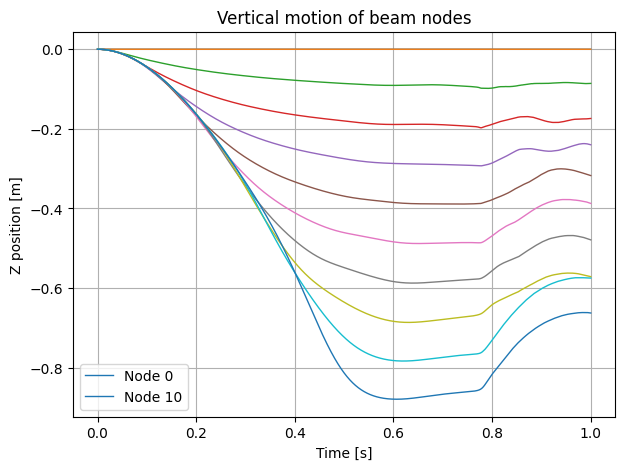

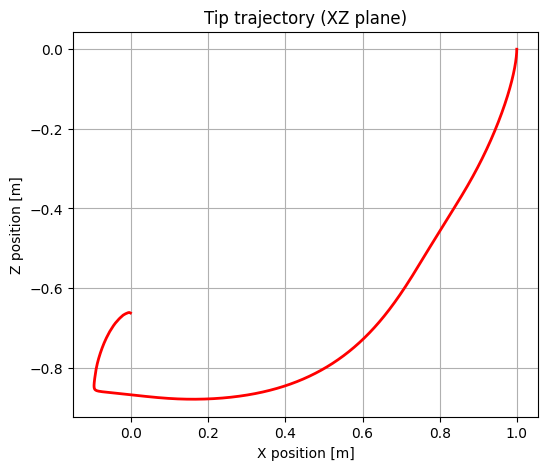

In [13]:
import matplotlib.pyplot as plt

# Convert trajectory to numpy
q_nodes = q_traj[:, :3*num_nodes]  # (T, 3*num_nodes)
q_traj_np = q_nodes.detach().cpu().numpy().reshape(len(t), num_nodes, 3)
t_np = t.detach().cpu().numpy()

# Plot Z-displacement (vertical motion) of each node
plt.figure(figsize=(7, 5))
for i in range(num_nodes):
    plt.plot(t_np, q_traj_np[:, i, 2], label=f'Node {i}' if i in [0, num_nodes-1] else "", lw=1)
plt.xlabel("Time [s]")
plt.ylabel("Z position [m]")
plt.title("Vertical motion of beam nodes")
plt.legend()
plt.grid(True)
plt.show()

# Plot trajectory of beam tip (last node)
plt.figure(figsize=(6, 5))
plt.plot(q_traj_np[:, -1, 0], q_traj_np[:, -1, 2], 'r-', lw=2)
plt.xlabel("X position [m]")
plt.ylabel("Z position [m]")
plt.title("Tip trajectory (XZ plane)")
plt.grid(True)
plt.show()


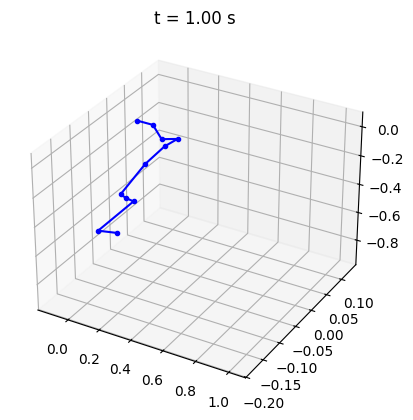

In [14]:
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.cla()
    ax.plot(q_traj_np[frame, :, 0],
            q_traj_np[frame, :, 1],
            q_traj_np[frame, :, 2],
            'b.-')
    ax.set_xlim([q_traj_np[:, :, 0].min()-0.1, q_traj_np[:, :, 0].max()+0.1])
    ax.set_ylim([q_traj_np[:, :, 1].min()-0.1, q_traj_np[:, :, 1].max()+0.1])
    ax.set_zlim([q_traj_np[:, :, 2].min()-0.1, q_traj_np[:, :, 2].max()+0.1])
    ax.set_title(f"t = {t[frame]:.2f} s")
    return ax

ani = animation.FuncAnimation(fig, update, frames=range(0, len(t), 100), interval=50)
ani.save("analytical_3drod.gif", writer="ffmpeg", fps=20)
plt.show()
